In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch import nn, einsum
from einops import rearrange

from utils.data import RandomLinearProjectionMNIST, DATA_PATH, get_mnist_data_loaders, get_emnist_data_loaders, select_from_classes
from utils.visualization import show_imgs, get_model_dot, LivePlot
from utils.others import measure_alloc_mem, count_parameters
from utils.timing import func_timer
from utils.metrics import get_accuracy

#import wandb
from IPython.display import clear_output
import tqdm
from livelossplot import PlotLosses
import lovely_tensors as lt

lt.monkey_patch()
torch.set_printoptions(precision=3, linewidth=180)
%env "WANDB_NOTEBOOK_NAME" "explore.ipynb"
#wandb.login()
DATA_PATH = os.path.join(os.getcwd(),"data")
#print(DATA_PATH)
np.random.seed(0)
torch.manual_seed(0)

env: "WANDB_NOTEBOOK_NAME"="explore.ipynb"


In [2]:
config = {
    "epochs": 40,
    "batch_size": 128,
    "seq_len": 100,
    "num_of_tasks": 2**16,
    "permuted_images_frac": 1.0,
    "permuted_labels_frac": 0.1,
    # "whole_seq_prediction": True,
    "whole_seq_prediction": False,
    "lr": 3e-4,
    "eps": 1e-16,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "ckpt_dir": "artifacts/models",
    "ckpt_freq": 2,
    "in_context_learner": {
        "dim": 256,
        "depth": 4,
        "heads": 6,
        "dim_head": 32,
        "inner_dim": None, # fill in below
        "dropout": 0.15,
        "whole_seq_prediction": None, # fill in below
    },
}
config["in_context_learner"]["inner_dim"] = config["in_context_learner"]["dim"] * 4
config["in_context_learner"]["whole_seq_prediction"] = config["whole_seq_prediction"]

print(f"... Running on {config['device']} ...")

... Running on cuda ...


# Data

In [4]:
train_mnist = datasets.MNIST(DATA_PATH, train=False, download=False, transform=RandomLinearProjectionMNIST.get_default_transform())

In [4]:
rand_lin_proj_mnist_dataset_train = RandomLinearProjectionMNIST(
    orig_mnist_dataset=datasets.MNIST(DATA_PATH, train=True, download=False, transform=RandomLinearProjectionMNIST.get_default_transform()),
    num_tasks=config["num_of_tasks"],
    seq_len=config["seq_len"],
    permuted_images_frac=config["permuted_images_frac"],
    permuted_labels_frac=config["permuted_labels_frac"],
    labels_shifted_by_one=config["whole_seq_prediction"]
)
train_loader = torch.utils.data.DataLoader(rand_lin_proj_mnist_dataset_train, batch_size=config["batch_size"], num_workers=8, shuffle=True)

rand_lin_proj_mnist_dataset_test = RandomLinearProjectionMNIST(
    orig_mnist_dataset=datasets.MNIST(DATA_PATH, train=False, download=False, transform=RandomLinearProjectionMNIST.get_default_transform()),
    num_tasks=config["num_of_tasks"],
    seq_len=config["seq_len"],
    permuted_images_frac=0.,
    permuted_labels_frac=0.,
    labels_shifted_by_one=config["whole_seq_prediction"]
)
test_loader = torch.utils.data.DataLoader(rand_lin_proj_mnist_dataset_test, batch_size=config["batch_size"],num_workers=8, shuffle=True)

### save dataloaders locally
torch.save(train_loader, "artifacts/data/train_loader.pt")
torch.save(test_loader, "artifacts/data/test_loader.pt")

In [3]:
### load dataloaders
train_loader = torch.load("artifacts/data/train_loader.pt")
test_loader = torch.load("artifacts/data/test_loader.pt")

KeyboardInterrupt: 

In [5]:
### perform a few data tests
def test_labels_shifted_by_one(data_loader):
    # test that the labels are shifted by one to the right
    for x, y in data_loader:
        assert x.shape == (config["batch_size"], config["seq_len"], 784 + 10)
        assert y.shape == (config["batch_size"], config["seq_len"])
        assert torch.all(x[:,0,-10:] == 0)
        assert torch.all(x[:,1:,-10:].argmax(-1) == y[:,:-1])
        break

def test_labels_not_shifted_by_one(data_loader):
    # test that the labels are not shifted by one to the right
    for x, y in data_loader:
        assert x.shape == (config["batch_size"], config["seq_len"], 784 + 10)
        assert y.shape == (config["batch_size"],)
        assert torch.all(x[:,-1,-10:] == 0)
        assert torch.all(x[:,:-1,-10:].max(-1).values == 1.)
        break

if config["whole_seq_prediction"]:
    test_labels_shifted_by_one(data_loader=train_loader)
    test_labels_shifted_by_one(data_loader=test_loader)
else:
    test_labels_not_shifted_by_one(data_loader=train_loader)
    test_labels_not_shifted_by_one(data_loader=test_loader)

KeyboardInterrupt: 

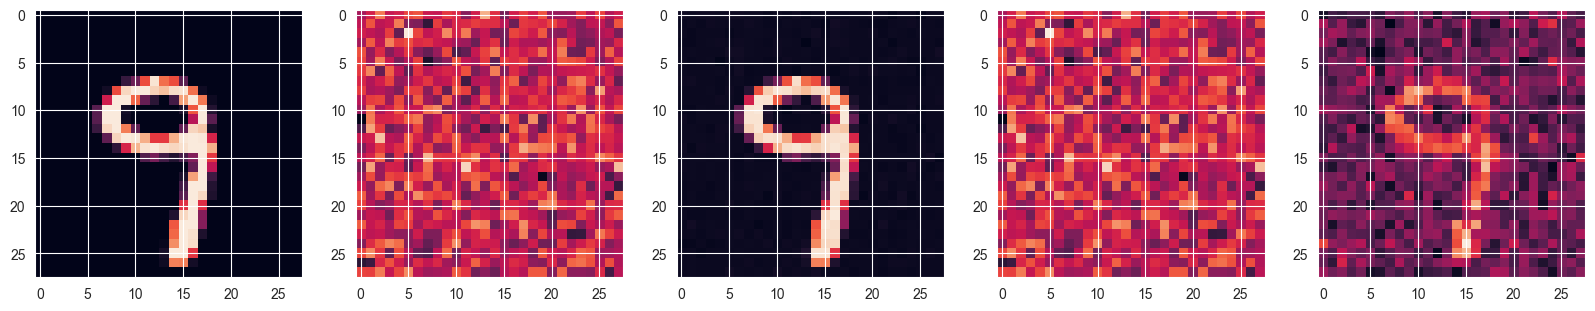

In [6]:
def show_dataset_projections(dataset):
    def get_pseudo_inverse(A, eps=1e-16):
        return torch.inverse(A.T @ A + eps * torch.eye(A.shape[1], device=A.device)) @ A.T
    lin_projection = dataset.get_lin_transform(0)
    lin_projection_inv = get_pseudo_inverse(lin_projection)

    task = dataset.get_task(0)
    orig_img = task[0][0].view(784)
    projected_img_manual = lin_projection @ orig_img
    # projected_img_manual = (projected_img_manual - projected_img_manual.mean()) / projected_img_manual.std()
    projected_img_manual_inv = lin_projection_inv @ projected_img_manual

    projected_img = dataset[0][0][0,:-10]
    projected_img_inv = (lin_projection_inv @ projected_img)
    projected_img_inv = (projected_img_inv - projected_img_inv.mean()) / projected_img_inv.std()

    show_imgs(torch.cat((orig_img.view(784), projected_img_manual, projected_img_manual_inv, projected_img, projected_img_inv), dim=0).view(-1,1,28,28))

show_dataset_projections(train_loader.dataset)

# Model

In [7]:
class Attention(nn.Module):
    def __init__(
        self,
        model_dim,
        heads=2,
        dim_head=16,
        dropout=0.,
        causal=False,
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.causal = causal
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(model_dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, model_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=self.heads), (q, k, v))
        sim = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        if self.causal:
            # apply causal mask
            mask = torch.ones(size=sim.shape[-2:], device=sim.device).triu_(1).bool()
            sim.masked_fill_(mask, float("-inf"))

        attn = sim.softmax(dim=-1) # (batch, heads, query, key)
        attn = self.dropout(attn)

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)", h=self.heads) # merge heads
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        heads,
        dim_head,
        token_dim=784 + 10,
        inner_dim=None,
        dropout=0.,
        causal=False,
    ):
        super().__init__()
        self.embed_proj = nn.Linear(token_dim, dim)
        self.layers = nn.ModuleList([])
        inner_dim = inner_dim or 4 * dim
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout, causal=causal),
                nn.LayerNorm(dim),
                nn.Sequential(
                    nn.Linear(dim, inner_dim),
                    nn.GELU(),
                    nn.Linear(inner_dim, dim),
                    nn.Dropout(dropout)
                ),
                nn.LayerNorm(dim)
            ]))

    def forward(self, x):
        x = self.embed_proj(x)
        for attn, ln1, mlp, ln2 in self.layers:
            x = x + attn(x)
            x = x + mlp(ln1(x))
        return x

class InContextLearner(nn.Module):
    def __init__(
        self,
        dim,
        depth=2,
        heads=4,
        dim_head=16,
        inner_dim=None,
        dropout=0.1,
        whole_seq_prediction=False,
    ):
        super().__init__()
        inner_dim = inner_dim or 4 * dim
        self.whole_seq_prediction = whole_seq_prediction
        self.transformer = Transformer(
            dim=dim,
            depth=depth,
            heads=heads,
            dim_head=dim_head,
            inner_dim=inner_dim,
            dropout=dropout,
            causal=whole_seq_prediction,
        )
        self.final_classifier = nn.Linear(dim, 10)

    def forward(self, x):
        x = self.transformer(x) # (batch, seq_len, dim)
        if self.whole_seq_prediction:
            return self.final_classifier(x)
        else:
            return self.final_classifier(x[:,-1,:])

model = InContextLearner(**config["in_context_learner"]).to(config["device"])

print(model)
print(f"{count_parameters(model)} trainable parameters")

InContextLearner(
  (transformer): Transformer(
    (embed_proj): Linear(in_features=794, out_features=256, bias=True)
    (layers): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (to_qkv): Linear(in_features=256, out_features=576, bias=False)
          (to_out): Linear(in_features=192, out_features=256, bias=True)
          (dropout): Dropout(p=0.15, inplace=False)
        )
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.15, inplace=False)
        )
        (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): ModuleList(
        (0): Attention(
          (to_qkv): Linear(in_features=256, out_features=576, bias=False)
          (to_out): Linear(in_features=192, out_features=256, bias=True)
          (dropout): D

# Utils

In [8]:
def eval(model, test_loader):
    model.eval()
    loss, acc = 0.0, 0.0
    acc_over_seq = np.zeros(config["seq_len"])
    acc_max_improvement_within_seq = 0.0
    with torch.no_grad():
        # loss, acc, acc_max_improvement_within_seq = 0, 0, 0
        # acc_over_seq = np.array([0.] * config["seq_len"])
        for x, y in test_loader:
            x, y = x.to(config["device"], non_blocking=True), y.to(config["device"], non_blocking=True)

            y_hat = model(x)
            if config["whole_seq_prediction"]:
                loss += F.cross_entropy(y_hat.view(-1, 10), y.view(-1)).item()
                accuracy_per_seq = (y_hat.argmax(dim=-1) == y).float().mean(dim=0)
                acc_over_seq += accuracy_per_seq.cpu().numpy()
                acc_improvement = (y_hat[:, 1:, :].argmax(dim=-1) == y[:, 1:]).float().max(dim=1).values
                acc_degradation = (y_hat[:, 0, :].argmax(dim=-1) == y[:, 0]).float()
                acc_max_improvement_within_seq += (acc_improvement - acc_degradation).mean().item()
            else:
                loss += F.cross_entropy(y_hat, y).item()
            acc += (y_hat.argmax(dim=-1) == y).float().mean().item()
        num_batches = len(test_loader)
        loss /= num_batches
        acc /= num_batches
        acc_over_seq /= num_batches
        acc_max_improvement_within_seq /= num_batches
        print(f"loss: {loss:.4f}, acc: {acc:.4f}")
    return loss, acc, list(acc_over_seq), acc_max_improvement_within_seq


In [21]:
def save_checkpoint(epoch, model, optimizer, loss_train, loss_eval, config):
    torch.save({
        "epoch": epoch,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss_train": loss_train,
        "loss_eval": loss_eval,
        "config": config,
    }, os.path.join(config["ckpt_dir"], f"model_{epoch}_{config['in_context_learner']['dim']}_{config['num_of_tasks']}.pt"))


In [10]:
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss_train = checkpoint["loss_train"]
    loss_eval = checkpoint["loss_eval"]
    config = checkpoint["config"]
    return model, optimizer, epoch, loss_train, loss_eval, config


# Training

In [11]:
model_optim = torch.optim.Adam(model.parameters(), lr=config["lr"], eps=config["eps"])

### logging
groups = ["train_loss", "train_acc", "eval_loss", "eval_acc"]
if config["whole_seq_prediction"]:
    groups.extend(["train_acc_over_seq", "train_acc_max_improvement_within_seq", "eval_acc_over_seq", "eval_acc_max_improvement_within_seq"])
live_plot = LivePlot(figsize=(26, 24) if config["whole_seq_prediction"] else (26, 14), use_seaborn=True, groups=groups)

In [12]:
### load model checkpoint
model, model_optim, start_epoch, loss_train, loss_eval, config = load_checkpoint(model, model_optim, os.path.join(config["ckpt_dir"], "model_4.pt"))

In [13]:
print(next(model.parameters()).device)

cuda:0


In [17]:
train_losses = []
train_accuracy = []
test_accuracy = []
test_losses = []

In [14]:
num_tasks_range = [2**i for i in range(4, 24)]  # Range of number of tasks
hidden_size_range = [2**i for i in range(4, 10)]  # Range of hidden sizes
#pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
results_list = []
for hidden_size in hidden_size_range:
    for num_tasks in num_tasks:
        config["num_of_tasks"] = num_tasks
        config["in_context_learner"]["dim"] = hidden_size
        config["in_context_learner"]["inner_dim"] = config["in_context_learner"]["dim"] * 4
        model_optim = torch.optim.Adam(model.parameters(), lr=config["lr"], eps=config["eps"])
        model = InContextLearner(**config["in_context_learner"]).to(config["device"])

        for epoch in tqdm.tqdm(range(start_epoch,config["epochs"])):
            model.train()
            for i, (x, y) in enumerate(train_loader):
                x, y = x.to(config["device"]), y.to(config["device"])
                y_hat = model(x)
                if config["whole_seq_prediction"]:
                    loss = F.cross_entropy(y_hat.view(-1, 10), y.view(-1))
                else:
                    loss = F.cross_entropy(y_hat, y)
                loss.backward()
                model_optim.step()
                model_optim.zero_grad()

                # update the plot
                # if i % 10 == 9:
                #     if config["whole_seq_prediction"]:
                #         acc_over_seq = (y_hat.argmax(dim=-1) == y).float().mean(dim=0) # (seq_len,)
                #         acc_max_improvement_within_seq = \
                #             ((y_hat[:,1:,:].argmax(dim=-1) == y[:,1:]).float().max(dim=-1).values \
                #             - (y_hat[:,0,:].argmax(dim=-1) == y[:,0]).float()).mean().item()
                    #     live_plot.update({"train_acc_over_seq": acc_over_seq.tolist()}, reset=True)
                    #     live_plot.update({"train_acc_max_improvement_within_seq": acc_max_improvement_within_seq})
                    # live_plot.update({"train_loss": loss.item(), "train_acc": (y_hat.argmax(dim=-1) == y).float().mean().item()})
                    # live_plot.draw()
                print(f"Training loss: {loss.item()}")
                print(f"Training accuracy {(y_hat.argmax(dim=-1) == y).float().mean().item()}")

            ### evaluate
            eval_loss, eval_acc, acc_over_seq, acc_max_improvement_within_seq = eval(model, test_loader)
            #live_plot.update({"eval_loss": eval_loss, "eval_acc": eval_acc})
            if config["whole_seq_prediction"]:
                print(acc_max_improvement_within_seq)
                print(acc_over_seq)
            #     live_plot.update({"eval_acc_max_improvement_within_seq": acc_max_improvement_within_seq})
            #     live_plot.update({"eval_acc_over_seq": acc_over_seq}, reset=True)
            # live_plot.draw()
            print(f"eval loss {eval_loss}")
            ### save model
            if epoch % config["ckpt_freq"] == 0:
                save_checkpoint(epoch=epoch, model=model, optimizer=model_optim, loss_train=loss.detach(), loss_eval=eval_loss, config=config)

  0%|          | 0/36 [00:00<?, ?it/s]

Training loss: 0.37589848041534424
Training accuracy 0.9140625
Training loss: 0.4656608998775482
Training accuracy 0.88671875
Training loss: 0.45757150650024414
Training accuracy 0.875
Training loss: 0.38646095991134644
Training accuracy 0.9140625
Training loss: 0.47215068340301514
Training accuracy 0.8828125
Training loss: 0.3631209433078766
Training accuracy 0.9296875
Training loss: 0.43915611505508423
Training accuracy 0.875
Training loss: 0.40212947130203247
Training accuracy 0.890625
Training loss: 0.3711760640144348
Training accuracy 0.9140625
Training loss: 0.4187106490135193
Training accuracy 0.90234375
Training loss: 0.481671005487442
Training accuracy 0.87109375
Training loss: 0.4277920722961426
Training accuracy 0.85546875
Training loss: 0.45339855551719666
Training accuracy 0.875
Training loss: 0.4617387652397156
Training accuracy 0.85546875
Training loss: 0.34761834144592285
Training accuracy 0.9140625
Training loss: 0.34107473492622375
Training accuracy 0.921875
Training 

  3%|▎         | 1/36 [03:58<2:19:05, 238.44s/it]

loss: 2.9058, acc: 0.2581
eval loss 2.9058297649025917
Training loss: 0.07267428189516068
Training accuracy 0.9921875
Training loss: 0.07709158211946487
Training accuracy 0.98828125
Training loss: 0.06789796054363251
Training accuracy 0.99609375
Training loss: 0.047605905681848526
Training accuracy 1.0
Training loss: 0.040039774030447006
Training accuracy 1.0
Training loss: 0.0507027693092823
Training accuracy 0.99609375
Training loss: 0.05669717863202095
Training accuracy 1.0
Training loss: 0.06742090731859207
Training accuracy 0.98828125
Training loss: 0.06014294549822807
Training accuracy 0.99609375
Training loss: 0.05040781572461128
Training accuracy 1.0
Training loss: 0.046839673072099686
Training accuracy 1.0
Training loss: 0.051531072705984116
Training accuracy 1.0
Training loss: 0.03784143552184105
Training accuracy 1.0
Training loss: 0.05400324612855911
Training accuracy 0.98828125
Training loss: 0.046822208911180496
Training accuracy 0.99609375
Training loss: 0.05781047046184

  6%|▌         | 2/36 [07:55<2:14:50, 237.96s/it]

loss: 3.7520, acc: 0.2944
eval loss 3.751967783086002
Training loss: 0.008423504419624805
Training accuracy 1.0
Training loss: 0.008159210905432701
Training accuracy 1.0
Training loss: 0.00871141068637371
Training accuracy 1.0
Training loss: 0.01327693834900856
Training accuracy 1.0
Training loss: 0.01283703651279211
Training accuracy 1.0
Training loss: 0.01834249123930931
Training accuracy 0.99609375
Training loss: 0.008191132918000221
Training accuracy 1.0
Training loss: 0.008014336228370667
Training accuracy 1.0
Training loss: 0.009918139316141605
Training accuracy 1.0
Training loss: 0.011385616846382618
Training accuracy 1.0
Training loss: 0.005740839522331953
Training accuracy 1.0
Training loss: 0.007838173769414425
Training accuracy 1.0
Training loss: 0.00870212446898222
Training accuracy 1.0
Training loss: 0.010750043205916882
Training accuracy 1.0
Training loss: 0.010210991837084293
Training accuracy 1.0
Training loss: 0.012866877019405365
Training accuracy 1.0
Training loss: 0

  8%|▊         | 3/36 [11:51<2:10:34, 237.42s/it]

loss: 4.3830, acc: 0.2836
eval loss 4.3830058528110385
Training loss: 0.0027861050330102444
Training accuracy 1.0
Training loss: 0.004669795278459787
Training accuracy 1.0
Training loss: 0.0032614925876259804
Training accuracy 1.0
Training loss: 0.004726762883365154
Training accuracy 1.0
Training loss: 0.004023087676614523
Training accuracy 1.0
Training loss: 0.0039594522677361965
Training accuracy 1.0
Training loss: 0.0034960582852363586
Training accuracy 1.0
Training loss: 0.002850412158295512
Training accuracy 1.0
Training loss: 0.004264356568455696
Training accuracy 1.0
Training loss: 0.0033135919366031885
Training accuracy 1.0
Training loss: 0.0040201423689723015
Training accuracy 1.0
Training loss: 0.004142142366617918
Training accuracy 1.0
Training loss: 0.0035387345124036074
Training accuracy 1.0
Training loss: 0.006315520964562893
Training accuracy 1.0
Training loss: 0.002595691941678524
Training accuracy 1.0
Training loss: 0.0041979518719017506
Training accuracy 1.0
Training 

 11%|█         | 4/36 [15:47<2:06:28, 237.14s/it]

loss: 4.7455, acc: 0.2822
eval loss 4.7454591896384954
Training loss: 0.002435992704704404
Training accuracy 1.0
Training loss: 0.0032386488746851683
Training accuracy 1.0
Training loss: 0.005082848481833935
Training accuracy 1.0
Training loss: 0.002948135370388627
Training accuracy 1.0
Training loss: 0.0024663780350238085
Training accuracy 1.0
Training loss: 0.004374523647129536
Training accuracy 1.0
Training loss: 0.0030679162591695786
Training accuracy 1.0
Training loss: 0.0021805623546242714
Training accuracy 1.0
Training loss: 0.0018066802294924855
Training accuracy 1.0
Training loss: 0.0018681922229006886
Training accuracy 1.0
Training loss: 0.002192307962104678
Training accuracy 1.0
Training loss: 0.0033555184490978718
Training accuracy 1.0
Training loss: 0.0011202527675777674
Training accuracy 1.0
Training loss: 0.002151294145733118
Training accuracy 1.0
Training loss: 0.0024095315020531416
Training accuracy 1.0
Training loss: 0.002083385596051812
Training accuracy 1.0
Training

 14%|█▍        | 5/36 [19:45<2:02:34, 237.23s/it]

loss: 5.0463, acc: 0.2775
eval loss 5.0463474821299314
Training loss: 0.001266240025870502
Training accuracy 1.0
Training loss: 0.0017147083999589086
Training accuracy 1.0
Training loss: 0.0009754677885212004
Training accuracy 1.0
Training loss: 0.0012262363452464342
Training accuracy 1.0
Training loss: 0.0010749243665486574
Training accuracy 1.0
Training loss: 0.001043673837557435
Training accuracy 1.0
Training loss: 0.0018553470727056265
Training accuracy 1.0
Training loss: 0.001344455173239112
Training accuracy 1.0
Training loss: 0.001704173511825502
Training accuracy 1.0
Training loss: 0.0016637368826195598
Training accuracy 1.0
Training loss: 0.0014351605204865336
Training accuracy 1.0
Training loss: 0.001444367691874504
Training accuracy 1.0
Training loss: 0.002649101661518216
Training accuracy 1.0
Training loss: 0.0016327659832313657
Training accuracy 1.0
Training loss: 0.0013135838089510798
Training accuracy 1.0
Training loss: 0.0027409952599555254
Training accuracy 1.0
Trainin

 17%|█▋        | 6/36 [23:41<1:58:30, 237.03s/it]

loss: 5.3091, acc: 0.2811
eval loss 5.309052953496575
Training loss: 0.002198304980993271
Training accuracy 1.0
Training loss: 0.0006317576626315713
Training accuracy 1.0
Training loss: 0.0015263998648151755
Training accuracy 1.0
Training loss: 0.001458420418202877
Training accuracy 1.0
Training loss: 0.0017511086771264672
Training accuracy 1.0
Training loss: 0.0017268212977796793
Training accuracy 1.0
Training loss: 0.0032274972181767225
Training accuracy 1.0
Training loss: 0.0011650394881144166
Training accuracy 1.0
Training loss: 0.0014416500926017761
Training accuracy 1.0
Training loss: 0.0016890248516574502
Training accuracy 1.0
Training loss: 0.0012298310175538063
Training accuracy 1.0
Training loss: 0.0009534407872706652
Training accuracy 1.0
Training loss: 0.0015866728499531746
Training accuracy 1.0
Training loss: 0.0007914481102488935
Training accuracy 1.0
Training loss: 0.0012932791141793132
Training accuracy 1.0
Training loss: 0.0014441233361139894
Training accuracy 1.0
Trai

 19%|█▉        | 7/36 [27:39<1:54:39, 237.24s/it]

loss: 5.5956, acc: 0.2704
eval loss 5.595557529479265
Training loss: 0.0010857230518013239
Training accuracy 1.0
Training loss: 0.0027495550457388163
Training accuracy 1.0
Training loss: 0.0027296263724565506
Training accuracy 1.0
Training loss: 0.0010397504083812237
Training accuracy 1.0
Training loss: 0.001393504673615098
Training accuracy 1.0
Training loss: 0.0006463528261519969
Training accuracy 1.0
Training loss: 0.0009984446223825216
Training accuracy 1.0
Training loss: 0.0014887037687003613
Training accuracy 1.0
Training loss: 0.0013936389004811645
Training accuracy 1.0
Training loss: 0.00086676434148103
Training accuracy 1.0
Training loss: 0.0007309689535759389
Training accuracy 1.0
Training loss: 0.000972972484305501
Training accuracy 1.0
Training loss: 0.0010360776213929057
Training accuracy 1.0
Training loss: 0.0011386184487491846
Training accuracy 1.0
Training loss: 0.0008443809347227216
Training accuracy 1.0
Training loss: 0.0015323227271437645
Training accuracy 1.0
Traini

 22%|██▏       | 8/36 [31:35<1:50:34, 236.96s/it]

loss: 5.8781, acc: 0.2754
eval loss 5.878131067380309
Training loss: 0.0008573880768381059
Training accuracy 1.0
Training loss: 0.0012660023057833314
Training accuracy 1.0
Training loss: 0.0007724820170551538
Training accuracy 1.0
Training loss: 0.0006935453275218606
Training accuracy 1.0
Training loss: 0.0014395711477845907
Training accuracy 1.0
Training loss: 0.0008264041389338672
Training accuracy 1.0
Training loss: 0.0007904945523478091
Training accuracy 1.0
Training loss: 0.0008405305561609566
Training accuracy 1.0
Training loss: 0.005059384275227785
Training accuracy 0.99609375
Training loss: 0.0008022363181225955
Training accuracy 1.0
Training loss: 0.000855887308716774
Training accuracy 1.0
Training loss: 0.0012202062644064426
Training accuracy 1.0
Training loss: 0.0007820020546205342
Training accuracy 1.0
Training loss: 0.0007770571974106133
Training accuracy 1.0
Training loss: 0.0010859809117391706
Training accuracy 1.0
Training loss: 0.0010082786902785301
Training accuracy 1

 25%|██▌       | 9/36 [35:30<1:46:17, 236.20s/it]

loss: 6.0605, acc: 0.2850
eval loss 6.060463864356279
Training loss: 0.0009165211231447756
Training accuracy 1.0
Training loss: 0.0011596244294196367
Training accuracy 1.0
Training loss: 0.0022459381725639105
Training accuracy 1.0
Training loss: 0.0012195288436487317
Training accuracy 1.0
Training loss: 0.0026919872034341097
Training accuracy 1.0
Training loss: 0.0031959782354533672
Training accuracy 1.0
Training loss: 0.0010341376764699817
Training accuracy 1.0
Training loss: 0.0014088209718465805
Training accuracy 1.0
Training loss: 0.0018918475834652781
Training accuracy 1.0
Training loss: 0.0015153593849390745
Training accuracy 1.0
Training loss: 0.0018267843406647444
Training accuracy 1.0
Training loss: 0.0010365535272285342
Training accuracy 1.0
Training loss: 0.0006068652728572488
Training accuracy 1.0
Training loss: 0.0007931339787319303
Training accuracy 1.0
Training loss: 0.001829069689847529
Training accuracy 1.0
Training loss: 0.0012517367722466588
Training accuracy 1.0
Tra

 28%|██▊       | 10/36 [39:24<1:42:08, 235.70s/it]

loss: 5.6022, acc: 0.2571
eval loss 5.602212723344564
Training loss: 0.0316559337079525
Training accuracy 0.98828125
Training loss: 0.026791241019964218
Training accuracy 0.98828125
Training loss: 0.014114705845713615
Training accuracy 1.0
Training loss: 0.012579444795846939
Training accuracy 0.99609375
Training loss: 0.03841377794742584
Training accuracy 0.98046875
Training loss: 0.014321321621537209
Training accuracy 0.99609375
Training loss: 0.06310576945543289
Training accuracy 0.984375
Training loss: 0.02450406365096569
Training accuracy 0.9921875
Training loss: 0.027743065729737282
Training accuracy 0.98828125
Training loss: 0.02633165940642357
Training accuracy 0.98828125
Training loss: 0.03543064370751381
Training accuracy 0.984375
Training loss: 0.04615870118141174
Training accuracy 0.9765625
Training loss: 0.038933951407670975
Training accuracy 0.984375
Training loss: 0.03435676917433739
Training accuracy 0.984375
Training loss: 0.009767364710569382
Training accuracy 0.996093

 31%|███       | 11/36 [43:19<1:38:02, 235.31s/it]

loss: 3.1895, acc: 0.3000
eval loss 3.1894941767677665
Training loss: 0.1304357498884201
Training accuracy 0.9609375
Training loss: 0.15480121970176697
Training accuracy 0.953125
Training loss: 0.17149251699447632
Training accuracy 0.94140625
Training loss: 0.1595064103603363
Training accuracy 0.94921875
Training loss: 0.16871154308319092
Training accuracy 0.94921875
Training loss: 0.18390201032161713
Training accuracy 0.93359375
Training loss: 0.16670790314674377
Training accuracy 0.9609375
Training loss: 0.19150763750076294
Training accuracy 0.9453125
Training loss: 0.11309415847063065
Training accuracy 0.96875
Training loss: 0.1842956691980362
Training accuracy 0.93359375
Training loss: 0.18221083283424377
Training accuracy 0.9453125
Training loss: 0.19685232639312744
Training accuracy 0.94140625
Training loss: 0.1413879543542862
Training accuracy 0.9375
Training loss: 0.1663891226053238
Training accuracy 0.9453125
Training loss: 0.16730870306491852
Training accuracy 0.9375
Training

 33%|███▎      | 12/36 [47:18<1:34:38, 236.60s/it]

loss: 3.5625, acc: 0.3104
eval loss 3.562492902390659
Training loss: 0.04083238169550896
Training accuracy 0.9921875
Training loss: 0.0671699196100235
Training accuracy 0.98046875
Training loss: 0.03916657716035843
Training accuracy 0.98828125
Training loss: 0.08475658297538757
Training accuracy 0.96875
Training loss: 0.057890042662620544
Training accuracy 0.984375
Training loss: 0.07676852494478226
Training accuracy 0.96484375
Training loss: 0.05268292874097824
Training accuracy 0.9921875
Training loss: 0.0493815541267395
Training accuracy 0.98046875
Training loss: 0.06251924484968185
Training accuracy 0.984375
Training loss: 0.07781022787094116
Training accuracy 0.97265625
Training loss: 0.04713744297623634
Training accuracy 0.984375
Training loss: 0.06631139665842056
Training accuracy 0.97265625
Training loss: 0.03537100553512573
Training accuracy 0.99609375
Training loss: 0.03612026944756508
Training accuracy 0.99609375
Training loss: 0.06526023149490356
Training accuracy 0.9726562

 36%|███▌      | 13/36 [51:20<1:31:14, 238.00s/it]

loss: 4.1927, acc: 0.2692
eval loss 4.1926792385056615
Training loss: 0.03826669231057167
Training accuracy 0.98828125
Training loss: 0.04281312972307205
Training accuracy 0.9921875
Training loss: 0.02858506329357624
Training accuracy 0.9921875
Training loss: 0.042931582778692245
Training accuracy 0.98046875
Training loss: 0.01940191723406315
Training accuracy 0.9921875
Training loss: 0.02495461516082287
Training accuracy 0.99609375
Training loss: 0.03440951183438301
Training accuracy 0.98046875
Training loss: 0.03612170368432999
Training accuracy 0.984375
Training loss: 0.02779502607882023
Training accuracy 0.99609375
Training loss: 0.0331118181347847
Training accuracy 0.98828125
Training loss: 0.01678944192826748
Training accuracy 1.0
Training loss: 0.043265122920274734
Training accuracy 0.98046875
Training loss: 0.03379516303539276
Training accuracy 0.99609375
Training loss: 0.027522115036845207
Training accuracy 0.98828125
Training loss: 0.01672903448343277
Training accuracy 1.0
Tr

 39%|███▉      | 14/36 [55:20<1:27:28, 238.58s/it]

loss: 4.8048, acc: 0.2821
eval loss 4.804752225987613
Training loss: 0.036699987947940826
Training accuracy 0.98828125
Training loss: 0.01869288831949234
Training accuracy 0.9921875
Training loss: 0.04543713852763176
Training accuracy 0.984375
Training loss: 0.008920528925955296
Training accuracy 0.99609375
Training loss: 0.022005299106240273
Training accuracy 0.9921875
Training loss: 0.00961622316390276
Training accuracy 1.0
Training loss: 0.016956429928541183
Training accuracy 0.99609375
Training loss: 0.021088657900691032
Training accuracy 0.99609375
Training loss: 0.015994170680642128
Training accuracy 0.99609375
Training loss: 0.022844232618808746
Training accuracy 0.9921875
Training loss: 0.02426445297896862
Training accuracy 0.9921875
Training loss: 0.011734743602573872
Training accuracy 1.0
Training loss: 0.015752658247947693
Training accuracy 0.99609375
Training loss: 0.018529796972870827
Training accuracy 1.0
Training loss: 0.04660838469862938
Training accuracy 0.9921875
Trai

 42%|████▏     | 15/36 [59:20<1:23:41, 239.10s/it]

loss: 4.0482, acc: 0.3222
eval loss 4.048169016838074
Training loss: 0.026265541091561317
Training accuracy 0.9921875
Training loss: 0.011309424415230751
Training accuracy 1.0
Training loss: 0.01517704501748085
Training accuracy 0.99609375
Training loss: 0.052010323852300644
Training accuracy 0.984375
Training loss: 0.021365517750382423
Training accuracy 0.99609375
Training loss: 0.03357347473502159
Training accuracy 0.98828125
Training loss: 0.026568369939923286
Training accuracy 0.9921875
Training loss: 0.02700689062476158
Training accuracy 0.9921875
Training loss: 0.009151950478553772
Training accuracy 1.0
Training loss: 0.015627412125468254
Training accuracy 0.99609375
Training loss: 0.01573213003575802
Training accuracy 0.99609375
Training loss: 0.020560240373015404
Training accuracy 0.9921875
Training loss: 0.018363595008850098
Training accuracy 0.9921875
Training loss: 0.0065746065229177475
Training accuracy 1.0
Training loss: 0.01795056089758873
Training accuracy 0.9921875
Trai

 44%|████▍     | 16/36 [1:03:22<1:20:00, 240.01s/it]

loss: 4.9346, acc: 0.2966
eval loss 4.934556810185313
Training loss: 0.023727789521217346
Training accuracy 0.98828125
Training loss: 0.012813523411750793
Training accuracy 0.99609375
Training loss: 0.024094801396131516
Training accuracy 0.98828125
Training loss: 0.04720081761479378
Training accuracy 0.98828125
Training loss: 0.045240774750709534
Training accuracy 0.98046875
Training loss: 0.05226549506187439
Training accuracy 0.984375
Training loss: 0.03548690304160118
Training accuracy 0.984375
Training loss: 0.027029408141970634
Training accuracy 0.9921875
Training loss: 0.04255477339029312
Training accuracy 0.984375
Training loss: 0.015279827639460564
Training accuracy 1.0
Training loss: 0.038449905812740326
Training accuracy 0.984375
Training loss: 0.022074440494179726
Training accuracy 0.9921875
Training loss: 0.01765773631632328
Training accuracy 0.99609375
Training loss: 0.02203194610774517
Training accuracy 0.99609375
Training loss: 0.015249434858560562
Training accuracy 0.996

 47%|████▋     | 17/36 [1:07:23<1:16:07, 240.39s/it]

loss: 4.9588, acc: 0.2574
eval loss 4.958846002817154
Training loss: 0.0270893182605505
Training accuracy 0.9921875
Training loss: 0.038302868604660034
Training accuracy 0.9921875
Training loss: 0.023471377789974213
Training accuracy 0.98828125
Training loss: 0.03648506850004196
Training accuracy 0.99609375
Training loss: 0.031005319207906723
Training accuracy 0.99609375
Training loss: 0.01021621935069561
Training accuracy 1.0
Training loss: 0.07760127633810043
Training accuracy 0.9765625
Training loss: 0.02147294580936432
Training accuracy 0.98828125
Training loss: 0.03447124734520912
Training accuracy 0.98828125
Training loss: 0.038116466253995895
Training accuracy 0.98828125
Training loss: 0.020195402204990387
Training accuracy 0.9921875
Training loss: 0.026038937270641327
Training accuracy 0.9921875
Training loss: 0.054186686873435974
Training accuracy 0.984375
Training loss: 0.049087248742580414
Training accuracy 0.984375
Training loss: 0.040485162287950516
Training accuracy 0.992

 50%|█████     | 18/36 [1:11:17<1:11:33, 238.51s/it]

loss: 5.2290, acc: 0.2466
eval loss 5.228980267420411
Training loss: 0.016785770654678345
Training accuracy 1.0
Training loss: 0.039019715040922165
Training accuracy 0.99609375
Training loss: 0.032328471541404724
Training accuracy 0.9921875
Training loss: 0.04881339892745018
Training accuracy 0.98828125
Training loss: 0.03966021165251732
Training accuracy 0.98046875
Training loss: 0.02033393457531929
Training accuracy 0.98828125
Training loss: 0.019274655729532242
Training accuracy 0.99609375
Training loss: 0.036767493933439255
Training accuracy 0.98046875
Training loss: 0.03957613185048103
Training accuracy 0.98828125
Training loss: 0.037151630967855453
Training accuracy 0.98828125
Training loss: 0.0319683738052845
Training accuracy 0.98828125
Training loss: 0.045821771025657654
Training accuracy 0.984375
Training loss: 0.03439369797706604
Training accuracy 0.98828125
Training loss: 0.038978882133960724
Training accuracy 0.984375
Training loss: 0.06559137254953384
Training accuracy 0.

 53%|█████▎    | 19/36 [1:15:11<1:07:09, 237.03s/it]

loss: 4.7176, acc: 0.2629
eval loss 4.717575090005994
Training loss: 0.04417812079191208
Training accuracy 0.9921875
Training loss: 0.029122330248355865
Training accuracy 0.98828125
Training loss: 0.01486955676227808
Training accuracy 0.99609375
Training loss: 0.031561218202114105
Training accuracy 0.98828125
Training loss: 0.013333387672901154
Training accuracy 1.0
Training loss: 0.04016845300793648
Training accuracy 0.984375
Training loss: 0.022155355662107468
Training accuracy 0.9921875
Training loss: 0.04838261008262634
Training accuracy 0.984375
Training loss: 0.04872622340917587
Training accuracy 0.98046875
Training loss: 0.010623343288898468
Training accuracy 1.0
Training loss: 0.066563181579113
Training accuracy 0.9765625
Training loss: 0.02077600732445717
Training accuracy 0.9921875
Training loss: 0.014937454834580421
Training accuracy 0.99609375
Training loss: 0.02197076566517353
Training accuracy 0.99609375
Training loss: 0.029080886393785477
Training accuracy 0.98828125
Tra

 56%|█████▌    | 20/36 [1:19:07<1:03:05, 236.60s/it]

loss: 5.4136, acc: 0.2737
eval loss 5.413603626191616
Training loss: 0.0075264303013682365
Training accuracy 1.0
Training loss: 0.011782628484070301
Training accuracy 0.99609375
Training loss: 0.04989263787865639
Training accuracy 0.98828125
Training loss: 0.02521735057234764
Training accuracy 0.98828125
Training loss: 0.015755344182252884
Training accuracy 0.99609375
Training loss: 0.023941289633512497
Training accuracy 0.98828125
Training loss: 0.013322858139872551
Training accuracy 1.0
Training loss: 0.023692740127444267
Training accuracy 0.9921875
Training loss: 0.04732084274291992
Training accuracy 0.9765625
Training loss: 0.025788994506001472
Training accuracy 0.984375
Training loss: 0.020410653203725815
Training accuracy 0.98828125
Training loss: 0.03896224871277809
Training accuracy 0.984375
Training loss: 0.025618702173233032
Training accuracy 0.984375
Training loss: 0.01703307405114174
Training accuracy 1.0
Training loss: 0.018498487770557404
Training accuracy 0.99609375
Trai

 58%|█████▊    | 21/36 [1:23:01<59:00, 236.06s/it]  

loss: 5.2052, acc: 0.2742
eval loss 5.205181514844298
Training loss: 0.03952502831816673
Training accuracy 0.984375
Training loss: 0.0240909643471241
Training accuracy 0.984375
Training loss: 0.028194062411785126
Training accuracy 0.9921875
Training loss: 0.009767269715666771
Training accuracy 1.0
Training loss: 0.03146667033433914
Training accuracy 0.984375
Training loss: 0.04101765900850296
Training accuracy 0.99609375
Training loss: 0.026734396815299988
Training accuracy 0.9921875
Training loss: 0.02544049359858036
Training accuracy 0.98828125
Training loss: 0.05341615527868271
Training accuracy 0.984375
Training loss: 0.02954944595694542
Training accuracy 0.98828125
Training loss: 0.02696564793586731
Training accuracy 0.9921875
Training loss: 0.03360242396593094
Training accuracy 0.984375
Training loss: 0.01429042313247919
Training accuracy 0.99609375
Training loss: 0.018642300739884377
Training accuracy 0.9921875
Training loss: 0.01682938076555729
Training accuracy 0.9921875
Train

 61%|██████    | 22/36 [1:26:56<54:58, 235.59s/it]

loss: 5.6991, acc: 0.2740
eval loss 5.699117271229625
Training loss: 0.02980829030275345
Training accuracy 0.98828125
Training loss: 0.02230878360569477
Training accuracy 0.99609375
Training loss: 0.022721828892827034
Training accuracy 0.9921875
Training loss: 0.03150054067373276
Training accuracy 0.98828125
Training loss: 0.010546499863266945
Training accuracy 1.0
Training loss: 0.024308282881975174
Training accuracy 0.9921875
Training loss: 0.024838918820023537
Training accuracy 0.9921875
Training loss: 0.031624890863895416
Training accuracy 0.98828125
Training loss: 0.023835215717554092
Training accuracy 0.99609375
Training loss: 0.016271168366074562
Training accuracy 0.9921875
Training loss: 0.0361090712249279
Training accuracy 0.99609375
Training loss: 0.024990616366267204
Training accuracy 0.9921875
Training loss: 0.04711969569325447
Training accuracy 0.98828125
Training loss: 0.030639899894595146
Training accuracy 0.9921875
Training loss: 0.023516282439231873
Training accuracy 0

 64%|██████▍   | 23/36 [1:30:51<51:00, 235.39s/it]

loss: 5.4140, acc: 0.3005
eval loss 5.413961015641689
Training loss: 0.04079505428671837
Training accuracy 0.98828125
Training loss: 0.015556751750409603
Training accuracy 0.99609375
Training loss: 0.0418504998087883
Training accuracy 0.98828125
Training loss: 0.021786702796816826
Training accuracy 0.99609375
Training loss: 0.02221747487783432
Training accuracy 0.9921875
Training loss: 0.02124650590121746
Training accuracy 0.98828125
Training loss: 0.026567360386252403
Training accuracy 0.98828125
Training loss: 0.01455716136842966
Training accuracy 0.99609375
Training loss: 0.017386453226208687
Training accuracy 0.9921875
Training loss: 0.037728048861026764
Training accuracy 0.984375
Training loss: 0.023699786514043808
Training accuracy 0.98828125
Training loss: 0.0193517804145813
Training accuracy 0.99609375
Training loss: 0.011289509013295174
Training accuracy 0.99609375
Training loss: 0.039345644414424896
Training accuracy 0.984375
Training loss: 0.016894690692424774
Training accur

 67%|██████▋   | 24/36 [1:34:47<47:07, 235.65s/it]

loss: 5.4017, acc: 0.2986
eval loss 5.401690647006035
Training loss: 0.020684614777565002
Training accuracy 0.9921875
Training loss: 0.03786027058959007
Training accuracy 0.984375
Training loss: 0.03295908495783806
Training accuracy 0.984375
Training loss: 0.010362775065004826
Training accuracy 1.0
Training loss: 0.00854839850217104
Training accuracy 1.0
Training loss: 0.02777773141860962
Training accuracy 0.9921875
Training loss: 0.017562368884682655
Training accuracy 0.9921875
Training loss: 0.014387108385562897
Training accuracy 1.0
Training loss: 0.03266872465610504
Training accuracy 0.98828125
Training loss: 0.04685920476913452
Training accuracy 0.98046875
Training loss: 0.03620506823062897
Training accuracy 0.984375
Training loss: 0.05667945370078087
Training accuracy 0.9765625
Training loss: 0.03591816499829292
Training accuracy 0.98828125
Training loss: 0.01663566380739212
Training accuracy 0.99609375
Training loss: 0.026807472109794617
Training accuracy 0.9921875
Training loss

 69%|██████▉   | 25/36 [1:38:44<43:15, 235.94s/it]

loss: 5.0380, acc: 0.3285
eval loss 5.038015836849809
Training loss: 0.00634233932942152
Training accuracy 1.0
Training loss: 0.02544492669403553
Training accuracy 0.98828125
Training loss: 0.02560158260166645
Training accuracy 0.98828125
Training loss: 0.012129118666052818
Training accuracy 0.9921875
Training loss: 0.021865101531147957
Training accuracy 0.98828125
Training loss: 0.04044255241751671
Training accuracy 0.98046875
Training loss: 0.03006364032626152
Training accuracy 0.98828125
Training loss: 0.03840456157922745
Training accuracy 0.9921875
Training loss: 0.011718581430613995
Training accuracy 1.0
Training loss: 0.027409832924604416
Training accuracy 0.98828125
Training loss: 0.015181169845163822
Training accuracy 0.99609375
Training loss: 0.016281193122267723
Training accuracy 0.99609375
Training loss: 0.07443647086620331
Training accuracy 0.9765625
Training loss: 0.018924973905086517
Training accuracy 0.9921875
Training loss: 0.03172782063484192
Training accuracy 0.988281

 72%|███████▏  | 26/36 [1:42:40<39:19, 235.92s/it]

loss: 5.3679, acc: 0.3017
eval loss 5.36788828112185
Training loss: 0.03863689303398132
Training accuracy 0.98828125
Training loss: 0.014108008705079556
Training accuracy 0.99609375
Training loss: 0.022503778338432312
Training accuracy 0.984375
Training loss: 0.009668318554759026
Training accuracy 0.99609375
Training loss: 0.010810033418238163
Training accuracy 0.99609375
Training loss: 0.01476572547107935
Training accuracy 1.0
Training loss: 0.032243743538856506
Training accuracy 0.984375
Training loss: 0.024372901767492294
Training accuracy 0.9921875
Training loss: 0.005945343058556318
Training accuracy 1.0
Training loss: 0.030338380485773087
Training accuracy 0.98828125
Training loss: 0.01266296487301588
Training accuracy 0.99609375
Training loss: 0.012282962910830975
Training accuracy 0.9921875
Training loss: 0.03676043078303337
Training accuracy 0.984375
Training loss: 0.04436779022216797
Training accuracy 0.98828125
Training loss: 0.05754612758755684
Training accuracy 0.97265625


 75%|███████▌  | 27/36 [1:46:35<35:22, 235.87s/it]

loss: 6.3938, acc: 0.2802
eval loss 6.393768683075905
Training loss: 0.030650287866592407
Training accuracy 0.98828125
Training loss: 0.010864547453820705
Training accuracy 1.0
Training loss: 0.02959306724369526
Training accuracy 0.9921875
Training loss: 0.035550788044929504
Training accuracy 0.9921875
Training loss: 0.029986845329403877
Training accuracy 0.98828125
Training loss: 0.04546937718987465
Training accuracy 0.984375
Training loss: 0.011178486049175262
Training accuracy 1.0
Training loss: 0.007064203266054392
Training accuracy 1.0
Training loss: 0.06324592232704163
Training accuracy 0.98046875
Training loss: 0.018277233466506004
Training accuracy 0.98828125
Training loss: 0.007005916442722082
Training accuracy 1.0
Training loss: 0.0349719412624836
Training accuracy 0.984375
Training loss: 0.011011180467903614
Training accuracy 1.0
Training loss: 0.0388394333422184
Training accuracy 0.9921875
Training loss: 0.008501882664859295
Training accuracy 1.0
Training loss: 0.0245477519

 78%|███████▊  | 28/36 [1:50:31<31:27, 235.93s/it]

loss: 6.3864, acc: 0.2672
eval loss 6.3863685466349125
Training loss: 0.030650893226265907
Training accuracy 0.9921875
Training loss: 0.052845548838377
Training accuracy 0.98046875
Training loss: 0.02660747431218624
Training accuracy 0.9921875
Training loss: 0.029880061745643616
Training accuracy 0.984375
Training loss: 0.025348830968141556
Training accuracy 0.98828125
Training loss: 0.02293199487030506
Training accuracy 0.9921875
Training loss: 0.018223518505692482
Training accuracy 0.99609375
Training loss: 0.016607550904154778
Training accuracy 0.9921875
Training loss: 0.043032459914684296
Training accuracy 0.98828125
Training loss: 0.03930090740323067
Training accuracy 0.99609375
Training loss: 0.013221928849816322
Training accuracy 0.99609375
Training loss: 0.017658967524766922
Training accuracy 0.99609375
Training loss: 0.08581938594579697
Training accuracy 0.98046875
Training loss: 0.02264806628227234
Training accuracy 0.98828125
Training loss: 0.009659787639975548
Training accu

 81%|████████  | 29/36 [1:54:25<27:26, 235.28s/it]

loss: 6.1139, acc: 0.2959
eval loss 6.11386763677001
Training loss: 0.029866041615605354
Training accuracy 0.98828125
Training loss: 0.00607330072671175
Training accuracy 1.0
Training loss: 0.01281109731644392
Training accuracy 0.9921875
Training loss: 0.06960392743349075
Training accuracy 0.984375
Training loss: 0.015723221004009247
Training accuracy 0.99609375
Training loss: 0.030182339251041412
Training accuracy 0.9921875
Training loss: 0.009359379298985004
Training accuracy 0.99609375
Training loss: 0.04168303310871124
Training accuracy 0.984375
Training loss: 0.015122488141059875
Training accuracy 0.99609375
Training loss: 0.011424127034842968
Training accuracy 0.9921875
Training loss: 0.00935825053602457
Training accuracy 1.0
Training loss: 0.03719567134976387
Training accuracy 0.98828125
Training loss: 0.009433050639927387
Training accuracy 1.0
Training loss: 0.011666996404528618
Training accuracy 0.99609375
Training loss: 0.012963451445102692
Training accuracy 0.99609375
Traini

 83%|████████▎ | 30/36 [1:58:22<23:34, 235.67s/it]

loss: 5.8423, acc: 0.3057
eval loss 5.842277090996504
Training loss: 0.014542377553880215
Training accuracy 1.0
Training loss: 0.011604237370193005
Training accuracy 0.99609375
Training loss: 0.02273908443748951
Training accuracy 0.9921875
Training loss: 0.03268013522028923
Training accuracy 0.98828125
Training loss: 0.018456973135471344
Training accuracy 0.9921875
Training loss: 0.027152065187692642
Training accuracy 0.9921875
Training loss: 0.015009310096502304
Training accuracy 0.9921875
Training loss: 0.025279484689235687
Training accuracy 0.98828125
Training loss: 0.02155003696680069
Training accuracy 0.9921875
Training loss: 0.009700505062937737
Training accuracy 0.99609375
Training loss: 0.044816624373197556
Training accuracy 0.98046875
Training loss: 0.010957944206893444
Training accuracy 0.99609375
Training loss: 0.03722378984093666
Training accuracy 0.984375
Training loss: 0.005123916082084179
Training accuracy 1.0
Training loss: 0.009600158780813217
Training accuracy 0.99609

 86%|████████▌ | 31/36 [2:02:22<19:45, 237.15s/it]

loss: 5.7797, acc: 0.2987
eval loss 5.779699953272939
Training loss: 0.015206946060061455
Training accuracy 0.9921875
Training loss: 0.02111104317009449
Training accuracy 0.99609375
Training loss: 0.0037664691917598248
Training accuracy 1.0
Training loss: 0.018757376819849014
Training accuracy 0.9921875
Training loss: 0.017204754054546356
Training accuracy 0.9921875
Training loss: 0.009755893610417843
Training accuracy 0.99609375
Training loss: 0.018313908949494362
Training accuracy 0.99609375
Training loss: 0.011611697264015675
Training accuracy 0.9921875
Training loss: 0.016397960484027863
Training accuracy 0.9921875
Training loss: 0.02714085765182972
Training accuracy 0.98828125
Training loss: 0.014260943047702312
Training accuracy 0.9921875
Training loss: 0.015799392014741898
Training accuracy 0.9921875
Training loss: 0.01129396166652441
Training accuracy 0.99609375
Training loss: 0.009441586211323738
Training accuracy 0.99609375
Training loss: 0.01584697514772415
Training accuracy

 89%|████████▉ | 32/36 [2:06:22<15:51, 237.81s/it]

loss: 5.4083, acc: 0.3118
eval loss 5.4082997515797615
Training loss: 0.02283494733273983
Training accuracy 0.9921875
Training loss: 0.052667874842882156
Training accuracy 0.984375
Training loss: 0.021884454414248466
Training accuracy 0.9921875
Training loss: 0.026811616495251656
Training accuracy 0.984375
Training loss: 0.03234873712062836
Training accuracy 0.98828125
Training loss: 0.008924228139221668
Training accuracy 1.0
Training loss: 0.018097003921866417
Training accuracy 0.99609375
Training loss: 0.0260249525308609
Training accuracy 0.98828125
Training loss: 0.012628039345145226
Training accuracy 1.0
Training loss: 0.016721727326512337
Training accuracy 0.9921875
Training loss: 0.024146107956767082
Training accuracy 0.98828125
Training loss: 0.0366361029446125
Training accuracy 0.984375
Training loss: 0.020375343039631844
Training accuracy 0.9921875
Training loss: 0.02940228208899498
Training accuracy 0.9921875
Training loss: 0.011367416009306908
Training accuracy 0.9921875
Tra

 92%|█████████▏| 33/36 [2:10:19<11:52, 237.53s/it]

loss: 5.8562, acc: 0.3150
eval loss 5.856206335127354
Training loss: 0.01658676192164421
Training accuracy 0.99609375
Training loss: 0.00975214783102274
Training accuracy 1.0
Training loss: 0.04499545693397522
Training accuracy 0.984375
Training loss: 0.020517464727163315
Training accuracy 0.98828125
Training loss: 0.02215767279267311
Training accuracy 0.9921875
Training loss: 0.023391691967844963
Training accuracy 0.9921875
Training loss: 0.030707864090800285
Training accuracy 0.98828125
Training loss: 0.03383002430200577
Training accuracy 0.98828125
Training loss: 0.026261253282427788
Training accuracy 0.98828125
Training loss: 0.0068138521164655685
Training accuracy 1.0
Training loss: 0.009610114619135857
Training accuracy 0.9921875
Training loss: 0.019656578078866005
Training accuracy 0.99609375
Training loss: 0.03207988664507866
Training accuracy 0.984375
Training loss: 0.03189660981297493
Training accuracy 0.984375
Training loss: 0.05280393362045288
Training accuracy 0.98046875
T

 94%|█████████▍| 34/36 [2:14:14<07:54, 237.01s/it]

loss: 5.1467, acc: 0.3139
eval loss 5.146650904789567
Training loss: 0.009577224962413311
Training accuracy 1.0
Training loss: 0.014831026084721088
Training accuracy 0.99609375
Training loss: 0.03107038512825966
Training accuracy 0.9921875
Training loss: 0.013331103138625622
Training accuracy 0.99609375
Training loss: 0.032775696367025375
Training accuracy 0.9921875
Training loss: 0.027243513613939285
Training accuracy 0.98828125
Training loss: 0.026477644219994545
Training accuracy 0.9921875
Training loss: 0.024512823671102524
Training accuracy 0.98828125
Training loss: 0.019989773631095886
Training accuracy 0.9921875
Training loss: 0.01656075194478035
Training accuracy 0.99609375
Training loss: 0.027641557157039642
Training accuracy 0.984375
Training loss: 0.0064423661679029465
Training accuracy 1.0
Training loss: 0.04130452126264572
Training accuracy 0.98828125
Training loss: 0.016822516918182373
Training accuracy 0.9921875
Training loss: 0.02235664799809456
Training accuracy 0.9921

 97%|█████████▋| 35/36 [2:18:14<03:57, 237.84s/it]

loss: 5.7789, acc: 0.3231
eval loss 5.778931964188814
Training loss: 0.012252062559127808
Training accuracy 0.9921875
Training loss: 0.01080595888197422
Training accuracy 0.99609375
Training loss: 0.03898809105157852
Training accuracy 0.9921875
Training loss: 0.05362093076109886
Training accuracy 0.984375
Training loss: 0.01941283792257309
Training accuracy 0.9921875
Training loss: 0.038277216255664825
Training accuracy 0.9921875
Training loss: 0.03880506753921509
Training accuracy 0.9921875
Training loss: 0.025048429146409035
Training accuracy 0.98828125
Training loss: 0.043933968991041183
Training accuracy 0.984375
Training loss: 0.017695065587759018
Training accuracy 0.9921875
Training loss: 0.009050079621374607
Training accuracy 1.0
Training loss: 0.03039083629846573
Training accuracy 0.98828125
Training loss: 0.013033954426646233
Training accuracy 1.0
Training loss: 0.012209679931402206
Training accuracy 0.9921875
Training loss: 0.02688976190984249
Training accuracy 0.99609375
Tra

100%|██████████| 36/36 [2:22:15<00:00, 237.11s/it]

loss: 6.0510, acc: 0.3200
eval loss 6.051029317080975


In [18]:
train_losses = []
train_accuracy = []
test_accuracy = []
test_losses = []
config["in_context_learner"]["dim"] = 128
config["in_context_learner"]["inner_dim"] = config["in_context_learner"]["dim"] * 4
model = InContextLearner(**config["in_context_learner"]).to(config["device"])
for epoch in tqdm.tqdm(range(start_epoch,config["epochs"])):
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(config["device"]), y.to(config["device"])
        y_hat = model(x)
        if config["whole_seq_prediction"]:
            loss = F.cross_entropy(y_hat.view(-1, 10), y.view(-1))
        else:
            loss = F.cross_entropy(y_hat, y)
        loss.backward()
        model_optim.step()
        model_optim.zero_grad()

        # update the plot
        # if i % 10 == 9:
        #     if config["whole_seq_prediction"]:
        #         acc_over_seq = (y_hat.argmax(dim=-1) == y).float().mean(dim=0) # (seq_len,)
        #         acc_max_improvement_within_seq = \
        #             ((y_hat[:,1:,:].argmax(dim=-1) == y[:,1:]).float().max(dim=-1).values \
        #             - (y_hat[:,0,:].argmax(dim=-1) == y[:,0]).float()).mean().item()
            #     live_plot.update({"train_acc_over_seq": acc_over_seq.tolist()}, reset=True)
            #     live_plot.update({"train_acc_max_improvement_within_seq": acc_max_improvement_within_seq})
            # live_plot.update({"train_loss": loss.item(), "train_acc": (y_hat.argmax(dim=-1) == y).float().mean().item()})
            # live_plot.draw()
        train_losses.append(loss.item())
        train_accuracy.append((y_hat.argmax(dim=-1) == y).float().mean().item())
        print(f"Training loss: {loss.item()}")
        print(f"Training accuracy {(y_hat.argmax(dim=-1) == y).float().mean().item()}")

    ### evaluate
    eval_loss, eval_acc, acc_over_seq, acc_max_improvement_within_seq = eval(model, test_loader)
    #live_plot.update({"eval_loss": eval_loss, "eval_acc": eval_acc})
    if config["whole_seq_prediction"]:
        print(acc_max_improvement_within_seq)
        print(acc_over_seq)
    #     live_plot.update({"eval_acc_max_improvement_within_seq": acc_max_improvement_within_seq})
    #     live_plot.update({"eval_acc_over_seq": acc_over_seq}, reset=True)
    # live_plot.draw()
    print(f"eval loss {eval_loss}")
    test_accuracy.append(eval_acc)
    test_losses.append(eval_loss)
    ### save model
    if epoch % config["ckpt_freq"] == 0:
        save_checkpoint(epoch=epoch, model=model, optimizer=model_optim, loss_train=loss.detach(), loss_eval=eval_loss, config=config)

  0%|          | 0/36 [00:00<?, ?it/s]

Training loss: 2.355344772338867
Training accuracy 0.11328125
Training loss: 2.352262258529663
Training accuracy 0.12109375
Training loss: 2.4360461235046387
Training accuracy 0.0703125
Training loss: 2.429872989654541
Training accuracy 0.08984375
Training loss: 2.3914549350738525
Training accuracy 0.1171875
Training loss: 2.406686544418335
Training accuracy 0.0625
Training loss: 2.3858869075775146
Training accuracy 0.109375
Training loss: 2.3935742378234863
Training accuracy 0.109375
Training loss: 2.3675293922424316
Training accuracy 0.09765625
Training loss: 2.3444132804870605
Training accuracy 0.12890625
Training loss: 2.3926217555999756
Training accuracy 0.09765625
Training loss: 2.414520025253296
Training accuracy 0.109375
Training loss: 2.4145994186401367
Training accuracy 0.09765625
Training loss: 2.4070088863372803
Training accuracy 0.08203125
Training loss: 2.338331937789917
Training accuracy 0.125
Training loss: 2.3870654106140137
Training accuracy 0.09765625
Training loss: 

  3%|▎         | 1/36 [03:57<2:18:40, 237.73s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041442647576
Training loss: 2.402101516723633
Training accuracy 0.07421875
Training loss: 2.3867921829223633
Training accuracy 0.08984375
Training loss: 2.400524616241455
Training accuracy 0.08984375
Training loss: 2.3843066692352295
Training accuracy 0.078125
Training loss: 2.458031415939331
Training accuracy 0.0859375
Training loss: 2.382154703140259
Training accuracy 0.11328125
Training loss: 2.3665246963500977
Training accuracy 0.1171875
Training loss: 2.414022207260132
Training accuracy 0.11328125
Training loss: 2.354626417160034
Training accuracy 0.11328125
Training loss: 2.4218506813049316
Training accuracy 0.09765625
Training loss: 2.3988699913024902
Training accuracy 0.09765625
Training loss: 2.3937790393829346
Training accuracy 0.09375
Training loss: 2.3834228515625
Training accuracy 0.109375
Training loss: 2.4007279872894287
Training accuracy 0.109375
Training loss: 2.397016763687134
Training accuracy 0.09375
Training loss: 2.4045743

  6%|▌         | 2/36 [07:54<2:14:31, 237.39s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041163250804
Training loss: 2.3944671154022217
Training accuracy 0.109375
Training loss: 2.3821804523468018
Training accuracy 0.0859375
Training loss: 2.4226279258728027
Training accuracy 0.078125
Training loss: 2.3808064460754395
Training accuracy 0.109375
Training loss: 2.4046623706817627
Training accuracy 0.09765625
Training loss: 2.416703224182129
Training accuracy 0.07421875
Training loss: 2.427029609680176
Training accuracy 0.078125
Training loss: 2.3776116371154785
Training accuracy 0.09375
Training loss: 2.341310977935791
Training accuracy 0.1171875
Training loss: 2.390014410018921
Training accuracy 0.09375
Training loss: 2.3886547088623047
Training accuracy 0.10546875
Training loss: 2.371968984603882
Training accuracy 0.08984375
Training loss: 2.4038736820220947
Training accuracy 0.109375
Training loss: 2.371154308319092
Training accuracy 0.08203125
Training loss: 2.416314125061035
Training accuracy 0.09375
Training loss: 2.41203117370

  8%|▊         | 3/36 [11:47<2:09:49, 236.04s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904117256403
Training loss: 2.3954379558563232
Training accuracy 0.12109375
Training loss: 2.43498158454895
Training accuracy 0.08203125
Training loss: 2.432666778564453
Training accuracy 0.0703125
Training loss: 2.374749183654785
Training accuracy 0.10546875
Training loss: 2.4262213706970215
Training accuracy 0.07421875
Training loss: 2.403332233428955
Training accuracy 0.078125
Training loss: 2.3980507850646973
Training accuracy 0.08984375
Training loss: 2.366955518722534
Training accuracy 0.08984375
Training loss: 2.3691229820251465
Training accuracy 0.10546875
Training loss: 2.431201934814453
Training accuracy 0.09765625
Training loss: 2.3775107860565186
Training accuracy 0.109375
Training loss: 2.4093503952026367
Training accuracy 0.08203125
Training loss: 2.3916101455688477
Training accuracy 0.0859375
Training loss: 2.3799424171447754
Training accuracy 0.11328125
Training loss: 2.3967812061309814
Training accuracy 0.1015625
Training loss: 

 11%|█         | 4/36 [15:40<2:05:22, 235.09s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040958359838
Training loss: 2.353107213973999
Training accuracy 0.09765625
Training loss: 2.417139768600464
Training accuracy 0.07421875
Training loss: 2.4098081588745117
Training accuracy 0.078125
Training loss: 2.394566774368286
Training accuracy 0.1015625
Training loss: 2.432612657546997
Training accuracy 0.0859375
Training loss: 2.3757143020629883
Training accuracy 0.11328125
Training loss: 2.395479440689087
Training accuracy 0.09765625
Training loss: 2.395639419555664
Training accuracy 0.1015625
Training loss: 2.3699774742126465
Training accuracy 0.109375
Training loss: 2.4092941284179688
Training accuracy 0.1015625
Training loss: 2.404554843902588
Training accuracy 0.1015625
Training loss: 2.3979010581970215
Training accuracy 0.07421875
Training loss: 2.3861217498779297
Training accuracy 0.0859375
Training loss: 2.4112935066223145
Training accuracy 0.12890625
Training loss: 2.3923356533050537
Training accuracy 0.1015625
Training loss: 2.3

 14%|█▍        | 5/36 [19:36<2:01:44, 235.63s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904088385403
Training loss: 2.3795058727264404
Training accuracy 0.08203125
Training loss: 2.394928455352783
Training accuracy 0.109375
Training loss: 2.3909716606140137
Training accuracy 0.1015625
Training loss: 2.367161512374878
Training accuracy 0.140625
Training loss: 2.3982529640197754
Training accuracy 0.09765625
Training loss: 2.348865270614624
Training accuracy 0.109375
Training loss: 2.39925479888916
Training accuracy 0.11328125
Training loss: 2.3928403854370117
Training accuracy 0.08984375
Training loss: 2.4032251834869385
Training accuracy 0.08203125
Training loss: 2.448211908340454
Training accuracy 0.09375
Training loss: 2.4113881587982178
Training accuracy 0.1015625
Training loss: 2.3674814701080322
Training accuracy 0.13671875
Training loss: 2.445173740386963
Training accuracy 0.08984375
Training loss: 2.35119366645813
Training accuracy 0.1015625
Training loss: 2.402186632156372
Training accuracy 0.09375
Training loss: 2.383831501

 17%|█▋        | 6/36 [23:32<1:57:45, 235.51s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041247069836
Training loss: 2.4033825397491455
Training accuracy 0.08203125
Training loss: 2.411324977874756
Training accuracy 0.0859375
Training loss: 2.367640733718872
Training accuracy 0.12890625
Training loss: 2.379533290863037
Training accuracy 0.0703125
Training loss: 2.3256633281707764
Training accuracy 0.13671875
Training loss: 2.3924918174743652
Training accuracy 0.09765625
Training loss: 2.4306113719940186
Training accuracy 0.08203125
Training loss: 2.4081599712371826
Training accuracy 0.09765625
Training loss: 2.362910032272339
Training accuracy 0.09375
Training loss: 2.3679518699645996
Training accuracy 0.10546875
Training loss: 2.406468152999878
Training accuracy 0.08984375
Training loss: 2.4295032024383545
Training accuracy 0.08984375
Training loss: 2.4003496170043945
Training accuracy 0.09765625
Training loss: 2.372969150543213
Training accuracy 0.12109375
Training loss: 2.369086503982544
Training accuracy 0.08984375
Training los

 19%|█▉        | 7/36 [27:27<1:53:45, 235.35s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041181877255
Training loss: 2.325066566467285
Training accuracy 0.1171875
Training loss: 2.395253896713257
Training accuracy 0.09765625
Training loss: 2.3915114402770996
Training accuracy 0.10546875
Training loss: 2.4324748516082764
Training accuracy 0.07421875
Training loss: 2.4150969982147217
Training accuracy 0.0859375
Training loss: 2.3998029232025146
Training accuracy 0.09765625
Training loss: 2.4117560386657715
Training accuracy 0.10546875
Training loss: 2.3782777786254883
Training accuracy 0.13671875
Training loss: 2.3730368614196777
Training accuracy 0.109375
Training loss: 2.409128427505493
Training accuracy 0.09765625
Training loss: 2.4310638904571533
Training accuracy 0.0625
Training loss: 2.410374164581299
Training accuracy 0.0625
Training loss: 2.4128477573394775
Training accuracy 0.078125
Training loss: 2.4062395095825195
Training accuracy 0.10546875
Training loss: 2.415412187576294
Training accuracy 0.09375
Training loss: 2.40927

 22%|██▏       | 8/36 [31:23<1:49:57, 235.64s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041079431772
Training loss: 2.397141218185425
Training accuracy 0.1015625
Training loss: 2.3777272701263428
Training accuracy 0.1015625
Training loss: 2.4021568298339844
Training accuracy 0.08984375
Training loss: 2.42167592048645
Training accuracy 0.0625
Training loss: 2.4218904972076416
Training accuracy 0.06640625
Training loss: 2.37416934967041
Training accuracy 0.08984375
Training loss: 2.3913283348083496
Training accuracy 0.0703125
Training loss: 2.369051456451416
Training accuracy 0.08203125
Training loss: 2.3968050479888916
Training accuracy 0.09375
Training loss: 2.3804969787597656
Training accuracy 0.12109375
Training loss: 2.429932117462158
Training accuracy 0.08984375
Training loss: 2.4510438442230225
Training accuracy 0.0625
Training loss: 2.39684796333313
Training accuracy 0.1015625
Training loss: 2.3968122005462646
Training accuracy 0.09765625
Training loss: 2.383843421936035
Training accuracy 0.12890625
Training loss: 2.40002822

 25%|██▌       | 9/36 [35:15<1:45:34, 234.62s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041088745
Training loss: 2.409196376800537
Training accuracy 0.1015625
Training loss: 2.395447015762329
Training accuracy 0.08984375
Training loss: 2.381392240524292
Training accuracy 0.09375
Training loss: 2.394442081451416
Training accuracy 0.08984375
Training loss: 2.406592607498169
Training accuracy 0.10546875
Training loss: 2.4301750659942627
Training accuracy 0.09765625
Training loss: 2.38197922706604
Training accuracy 0.09765625
Training loss: 2.464085817337036
Training accuracy 0.08984375
Training loss: 2.396892547607422
Training accuracy 0.12109375
Training loss: 2.4038822650909424
Training accuracy 0.08984375
Training loss: 2.4030377864837646
Training accuracy 0.1015625
Training loss: 2.4517862796783447
Training accuracy 0.07421875
Training loss: 2.373047113418579
Training accuracy 0.09765625
Training loss: 2.3868117332458496
Training accuracy 0.0859375
Training loss: 2.341313600540161
Training accuracy 0.0859375
Training loss: 2.3662

 28%|██▊       | 10/36 [39:09<1:41:31, 234.28s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041051492095
Training loss: 2.4202189445495605
Training accuracy 0.10546875
Training loss: 2.4036972522735596
Training accuracy 0.08203125
Training loss: 2.3877851963043213
Training accuracy 0.10546875
Training loss: 2.351964235305786
Training accuracy 0.109375
Training loss: 2.3874270915985107
Training accuracy 0.12109375
Training loss: 2.38865065574646
Training accuracy 0.1171875
Training loss: 2.4016449451446533
Training accuracy 0.11328125
Training loss: 2.3381569385528564
Training accuracy 0.12890625
Training loss: 2.374263286590576
Training accuracy 0.12109375
Training loss: 2.4505984783172607
Training accuracy 0.05859375
Training loss: 2.405759811401367
Training accuracy 0.09375
Training loss: 2.373542308807373
Training accuracy 0.11328125
Training loss: 2.3772194385528564
Training accuracy 0.08203125
Training loss: 2.413726568222046
Training accuracy 0.08203125
Training loss: 2.407484531402588
Training accuracy 0.06640625
Training loss:

 31%|███       | 11/36 [42:58<1:37:03, 232.93s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041275009513
Training loss: 2.35638427734375
Training accuracy 0.11328125
Training loss: 2.4124999046325684
Training accuracy 0.07421875
Training loss: 2.3706247806549072
Training accuracy 0.10546875
Training loss: 2.3958139419555664
Training accuracy 0.0859375
Training loss: 2.4036478996276855
Training accuracy 0.08203125
Training loss: 2.442797899246216
Training accuracy 0.0703125
Training loss: 2.3850152492523193
Training accuracy 0.12109375
Training loss: 2.3467183113098145
Training accuracy 0.09375
Training loss: 2.425842761993408
Training accuracy 0.07421875
Training loss: 2.396897792816162
Training accuracy 0.09765625
Training loss: 2.3288979530334473
Training accuracy 0.1484375
Training loss: 2.360232353210449
Training accuracy 0.109375
Training loss: 2.3786120414733887
Training accuracy 0.1015625
Training loss: 2.4317731857299805
Training accuracy 0.1171875
Training loss: 2.3928678035736084
Training accuracy 0.11328125
Training loss: 2

 33%|███▎      | 12/36 [46:48<1:32:42, 231.77s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904106080532
Training loss: 2.342292547225952
Training accuracy 0.11328125
Training loss: 2.37184476852417
Training accuracy 0.08203125
Training loss: 2.404876470565796
Training accuracy 0.06640625
Training loss: 2.418252944946289
Training accuracy 0.10546875
Training loss: 2.3631041049957275
Training accuracy 0.12890625
Training loss: 2.3592910766601562
Training accuracy 0.10546875
Training loss: 2.356555461883545
Training accuracy 0.10546875
Training loss: 2.393688678741455
Training accuracy 0.109375
Training loss: 2.4023425579071045
Training accuracy 0.08203125
Training loss: 2.397200345993042
Training accuracy 0.09765625
Training loss: 2.399550199508667
Training accuracy 0.1015625
Training loss: 2.3705697059631348
Training accuracy 0.1171875
Training loss: 2.466407299041748
Training accuracy 0.078125
Training loss: 2.4227826595306396
Training accuracy 0.078125
Training loss: 2.3962740898132324
Training accuracy 0.12890625
Training loss: 2.39

 36%|███▌      | 13/36 [50:38<1:28:38, 231.23s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904106080532
Training loss: 2.397911310195923
Training accuracy 0.10546875
Training loss: 2.3874220848083496
Training accuracy 0.08203125
Training loss: 2.4007439613342285
Training accuracy 0.09375
Training loss: 2.4448537826538086
Training accuracy 0.06640625
Training loss: 2.397733211517334
Training accuracy 0.0859375
Training loss: 2.3898558616638184
Training accuracy 0.09375
Training loss: 2.396409273147583
Training accuracy 0.0859375
Training loss: 2.433565139770508
Training accuracy 0.0859375
Training loss: 2.39092755317688
Training accuracy 0.08203125
Training loss: 2.369791269302368
Training accuracy 0.09765625
Training loss: 2.394446849822998
Training accuracy 0.1171875
Training loss: 2.372877359390259
Training accuracy 0.10546875
Training loss: 2.4329285621643066
Training accuracy 0.0703125
Training loss: 2.42270827293396
Training accuracy 0.078125
Training loss: 2.367948055267334
Training accuracy 0.1015625
Training loss: 2.3612897396

 39%|███▉      | 14/36 [54:27<1:24:38, 230.84s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.41290411259979
Training loss: 2.393465518951416
Training accuracy 0.1015625
Training loss: 2.4198057651519775
Training accuracy 0.078125
Training loss: 2.4472758769989014
Training accuracy 0.07421875
Training loss: 2.418153762817383
Training accuracy 0.109375
Training loss: 2.4294989109039307
Training accuracy 0.109375
Training loss: 2.408376693725586
Training accuracy 0.0859375
Training loss: 2.3694546222686768
Training accuracy 0.078125
Training loss: 2.415321111679077
Training accuracy 0.0859375
Training loss: 2.384219169616699
Training accuracy 0.10546875
Training loss: 2.438476800918579
Training accuracy 0.07421875
Training loss: 2.3780670166015625
Training accuracy 0.12890625
Training loss: 2.348864793777466
Training accuracy 0.1015625
Training loss: 2.4210705757141113
Training accuracy 0.0859375
Training loss: 2.348954200744629
Training accuracy 0.0859375
Training loss: 2.3882336616516113
Training accuracy 0.0859375
Training loss: 2.40269899

 42%|████▏     | 15/36 [58:17<1:20:40, 230.52s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041079431772
Training loss: 2.369959592819214
Training accuracy 0.12109375
Training loss: 2.378530502319336
Training accuracy 0.12109375
Training loss: 2.404635190963745
Training accuracy 0.0859375
Training loss: 2.39998722076416
Training accuracy 0.06640625
Training loss: 2.356877326965332
Training accuracy 0.12890625
Training loss: 2.379085063934326
Training accuracy 0.11328125
Training loss: 2.414008855819702
Training accuracy 0.078125
Training loss: 2.389888048171997
Training accuracy 0.12109375
Training loss: 2.3636159896850586
Training accuracy 0.125
Training loss: 2.392918109893799
Training accuracy 0.1328125
Training loss: 2.3987157344818115
Training accuracy 0.078125
Training loss: 2.3683645725250244
Training accuracy 0.1171875
Training loss: 2.3866665363311768
Training accuracy 0.10546875
Training loss: 2.3989365100860596
Training accuracy 0.125
Training loss: 2.420840263366699
Training accuracy 0.10546875
Training loss: 2.44288849830

 44%|████▍     | 16/36 [1:02:07<1:16:47, 230.36s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904128432274
Training loss: 2.4019112586975098
Training accuracy 0.1015625
Training loss: 2.3841865062713623
Training accuracy 0.125
Training loss: 2.3711538314819336
Training accuracy 0.1015625
Training loss: 2.390407085418701
Training accuracy 0.09375
Training loss: 2.3768959045410156
Training accuracy 0.1328125
Training loss: 2.4229142665863037
Training accuracy 0.1015625
Training loss: 2.3921713829040527
Training accuracy 0.08984375
Training loss: 2.4485790729522705
Training accuracy 0.078125
Training loss: 2.4053053855895996
Training accuracy 0.0703125
Training loss: 2.3840324878692627
Training accuracy 0.10546875
Training loss: 2.408492088317871
Training accuracy 0.07421875
Training loss: 2.390899419784546
Training accuracy 0.08984375
Training loss: 2.315340518951416
Training accuracy 0.12890625
Training loss: 2.3831233978271484
Training accuracy 0.1015625
Training loss: 2.3636655807495117
Training accuracy 0.10546875
Training loss: 2.4609

 47%|████▋     | 17/36 [1:05:58<1:13:00, 230.56s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904094904661
Training loss: 2.3906354904174805
Training accuracy 0.11328125
Training loss: 2.3589539527893066
Training accuracy 0.1015625
Training loss: 2.416661024093628
Training accuracy 0.05859375
Training loss: 2.41001033782959
Training accuracy 0.12890625
Training loss: 2.400930643081665
Training accuracy 0.10546875
Training loss: 2.384945869445801
Training accuracy 0.08203125
Training loss: 2.3683066368103027
Training accuracy 0.10546875
Training loss: 2.3842201232910156
Training accuracy 0.09375
Training loss: 2.395439863204956
Training accuracy 0.1171875
Training loss: 2.431039333343506
Training accuracy 0.1015625
Training loss: 2.378749370574951
Training accuracy 0.0859375
Training loss: 2.400550365447998
Training accuracy 0.0703125
Training loss: 2.376708507537842
Training accuracy 0.1171875
Training loss: 2.348686933517456
Training accuracy 0.09375
Training loss: 2.3860912322998047
Training accuracy 0.1171875
Training loss: 2.40226960

 50%|█████     | 18/36 [1:09:49<1:09:10, 230.57s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040772095323
Training loss: 2.384190559387207
Training accuracy 0.0703125
Training loss: 2.4095818996429443
Training accuracy 0.09375
Training loss: 2.373596668243408
Training accuracy 0.09375
Training loss: 2.362414598464966
Training accuracy 0.1171875
Training loss: 2.3880882263183594
Training accuracy 0.1015625
Training loss: 2.411872386932373
Training accuracy 0.1171875
Training loss: 2.406210422515869
Training accuracy 0.078125
Training loss: 2.395176887512207
Training accuracy 0.1015625
Training loss: 2.438568592071533
Training accuracy 0.0703125
Training loss: 2.3990752696990967
Training accuracy 0.09765625
Training loss: 2.361112117767334
Training accuracy 0.140625
Training loss: 2.4067513942718506
Training accuracy 0.10546875
Training loss: 2.372406482696533
Training accuracy 0.1015625
Training loss: 2.3710758686065674
Training accuracy 0.11328125
Training loss: 2.4034764766693115
Training accuracy 0.1328125
Training loss: 2.4394717216

 53%|█████▎    | 19/36 [1:13:38<1:05:14, 230.27s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041070118546
Training loss: 2.4029934406280518
Training accuracy 0.10546875
Training loss: 2.3431670665740967
Training accuracy 0.08203125
Training loss: 2.417646884918213
Training accuracy 0.08203125
Training loss: 2.405170440673828
Training accuracy 0.09765625
Training loss: 2.427503824234009
Training accuracy 0.0703125
Training loss: 2.4109294414520264
Training accuracy 0.078125
Training loss: 2.391709327697754
Training accuracy 0.09765625
Training loss: 2.3788645267486572
Training accuracy 0.07421875
Training loss: 2.4078330993652344
Training accuracy 0.08203125
Training loss: 2.3938522338867188
Training accuracy 0.1015625
Training loss: 2.400531053543091
Training accuracy 0.0703125
Training loss: 2.4394664764404297
Training accuracy 0.09765625
Training loss: 2.3826828002929688
Training accuracy 0.08984375
Training loss: 2.405660390853882
Training accuracy 0.0859375
Training loss: 2.366421699523926
Training accuracy 0.11328125
Training loss

 56%|█████▌    | 20/36 [1:17:30<1:01:28, 230.54s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904106080532
Training loss: 2.3727078437805176
Training accuracy 0.1171875
Training loss: 2.385611057281494
Training accuracy 0.08984375
Training loss: 2.3778014183044434
Training accuracy 0.1015625
Training loss: 2.4011013507843018
Training accuracy 0.10546875
Training loss: 2.3803751468658447
Training accuracy 0.109375
Training loss: 2.3608486652374268
Training accuracy 0.15625
Training loss: 2.3720791339874268
Training accuracy 0.1015625
Training loss: 2.3949062824249268
Training accuracy 0.078125
Training loss: 2.435831308364868
Training accuracy 0.08203125
Training loss: 2.435736894607544
Training accuracy 0.08203125
Training loss: 2.4242050647735596
Training accuracy 0.078125
Training loss: 2.4141921997070312
Training accuracy 0.078125
Training loss: 2.342853307723999
Training accuracy 0.1171875
Training loss: 2.369436264038086
Training accuracy 0.1171875
Training loss: 2.3952364921569824
Training accuracy 0.1015625
Training loss: 2.429409

 58%|█████▊    | 21/36 [1:21:20<57:39, 230.62s/it]  

loss: 2.4129, acc: 0.0966
eval loss 2.4129040967673063
Training loss: 2.4143686294555664
Training accuracy 0.1015625
Training loss: 2.3689465522766113
Training accuracy 0.1171875
Training loss: 2.3731441497802734
Training accuracy 0.09765625
Training loss: 2.408092498779297
Training accuracy 0.08984375
Training loss: 2.368138313293457
Training accuracy 0.1015625
Training loss: 2.4461708068847656
Training accuracy 0.06640625
Training loss: 2.358036756515503
Training accuracy 0.13671875
Training loss: 2.4089999198913574
Training accuracy 0.078125
Training loss: 2.3967032432556152
Training accuracy 0.10546875
Training loss: 2.4271655082702637
Training accuracy 0.11328125
Training loss: 2.4108376502990723
Training accuracy 0.10546875
Training loss: 2.415889024734497
Training accuracy 0.0859375
Training loss: 2.372103452682495
Training accuracy 0.11328125
Training loss: 2.3899059295654297
Training accuracy 0.1015625
Training loss: 2.3839187622070312
Training accuracy 0.13671875
Training los

 61%|██████    | 22/36 [1:25:13<53:56, 231.15s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041209816933
Training loss: 2.4111344814300537
Training accuracy 0.09765625
Training loss: 2.413787364959717
Training accuracy 0.08203125
Training loss: 2.373202085494995
Training accuracy 0.11328125
Training loss: 2.368494987487793
Training accuracy 0.12890625
Training loss: 2.3956637382507324
Training accuracy 0.09765625
Training loss: 2.4138333797454834
Training accuracy 0.09765625
Training loss: 2.419637680053711
Training accuracy 0.09375
Training loss: 2.415839433670044
Training accuracy 0.0859375
Training loss: 2.4102890491485596
Training accuracy 0.09375
Training loss: 2.3729538917541504
Training accuracy 0.09375
Training loss: 2.3718390464782715
Training accuracy 0.12890625
Training loss: 2.47499680519104
Training accuracy 0.0859375
Training loss: 2.4156973361968994
Training accuracy 0.09765625
Training loss: 2.430328130722046
Training accuracy 0.078125
Training loss: 2.368263006210327
Training accuracy 0.15234375
Training loss: 2.39836

 64%|██████▍   | 23/36 [1:29:02<49:58, 230.65s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040902480483
Training loss: 2.380373477935791
Training accuracy 0.09765625
Training loss: 2.4070844650268555
Training accuracy 0.11328125
Training loss: 2.3670432567596436
Training accuracy 0.08984375
Training loss: 2.399022102355957
Training accuracy 0.1015625
Training loss: 2.4119369983673096
Training accuracy 0.0859375
Training loss: 2.3501217365264893
Training accuracy 0.12890625
Training loss: 2.431757688522339
Training accuracy 0.1171875
Training loss: 2.379013776779175
Training accuracy 0.08984375
Training loss: 2.3830015659332275
Training accuracy 0.08984375
Training loss: 2.428257942199707
Training accuracy 0.08984375
Training loss: 2.3749632835388184
Training accuracy 0.11328125
Training loss: 2.390536308288574
Training accuracy 0.07421875
Training loss: 2.3957314491271973
Training accuracy 0.1171875
Training loss: 2.361889362335205
Training accuracy 0.09765625
Training loss: 2.3982930183410645
Training accuracy 0.08203125
Training lo

 67%|██████▋   | 24/36 [1:32:51<46:00, 230.07s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040874540806
Training loss: 2.390667200088501
Training accuracy 0.09765625
Training loss: 2.407322406768799
Training accuracy 0.06640625
Training loss: 2.3597350120544434
Training accuracy 0.1328125
Training loss: 2.3949615955352783
Training accuracy 0.08203125
Training loss: 2.389415979385376
Training accuracy 0.109375
Training loss: 2.3912746906280518
Training accuracy 0.06640625
Training loss: 2.435940742492676
Training accuracy 0.109375
Training loss: 2.3596763610839844
Training accuracy 0.1171875
Training loss: 2.4064457416534424
Training accuracy 0.09375
Training loss: 2.385150194168091
Training accuracy 0.10546875
Training loss: 2.437556743621826
Training accuracy 0.0703125
Training loss: 2.373560667037964
Training accuracy 0.08984375
Training loss: 2.33512806892395
Training accuracy 0.1640625
Training loss: 2.3869941234588623
Training accuracy 0.09765625
Training loss: 2.3943278789520264
Training accuracy 0.0703125
Training loss: 2.3870

 69%|██████▉   | 25/36 [1:36:43<42:15, 230.53s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041135311127
Training loss: 2.374110460281372
Training accuracy 0.12109375
Training loss: 2.3763296604156494
Training accuracy 0.09375
Training loss: 2.3726658821105957
Training accuracy 0.11328125
Training loss: 2.3707141876220703
Training accuracy 0.12109375
Training loss: 2.3718783855438232
Training accuracy 0.1171875
Training loss: 2.4025280475616455
Training accuracy 0.09765625
Training loss: 2.3819544315338135
Training accuracy 0.078125
Training loss: 2.3764734268188477
Training accuracy 0.1015625
Training loss: 2.368384838104248
Training accuracy 0.10546875
Training loss: 2.34165358543396
Training accuracy 0.12890625
Training loss: 2.3886735439300537
Training accuracy 0.08984375
Training loss: 2.362081289291382
Training accuracy 0.125
Training loss: 2.455493688583374
Training accuracy 0.046875
Training loss: 2.4281702041625977
Training accuracy 0.08984375
Training loss: 2.370002031326294
Training accuracy 0.09375
Training loss: 2.3722944

 72%|███████▏  | 26/36 [1:40:33<38:23, 230.39s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040958359838
Training loss: 2.3767316341400146
Training accuracy 0.109375
Training loss: 2.3963654041290283
Training accuracy 0.1015625
Training loss: 2.351099729537964
Training accuracy 0.10546875
Training loss: 2.3877615928649902
Training accuracy 0.109375
Training loss: 2.4232466220855713
Training accuracy 0.07421875
Training loss: 2.4266765117645264
Training accuracy 0.08984375
Training loss: 2.367340326309204
Training accuracy 0.13671875
Training loss: 2.3962392807006836
Training accuracy 0.1015625
Training loss: 2.4319589138031006
Training accuracy 0.08203125
Training loss: 2.3760452270507812
Training accuracy 0.0859375
Training loss: 2.4399850368499756
Training accuracy 0.1015625
Training loss: 2.3910505771636963
Training accuracy 0.1171875
Training loss: 2.405195951461792
Training accuracy 0.0703125
Training loss: 2.4149253368377686
Training accuracy 0.10546875
Training loss: 2.3986141681671143
Training accuracy 0.1015625
Training loss:

 75%|███████▌  | 27/36 [1:44:22<34:31, 230.17s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904099561274
Training loss: 2.4091269969940186
Training accuracy 0.07421875
Training loss: 2.335641622543335
Training accuracy 0.1171875
Training loss: 2.394653558731079
Training accuracy 0.11328125
Training loss: 2.4447219371795654
Training accuracy 0.078125
Training loss: 2.3964102268218994
Training accuracy 0.078125
Training loss: 2.412968635559082
Training accuracy 0.1015625
Training loss: 2.372748613357544
Training accuracy 0.1171875
Training loss: 2.3762354850769043
Training accuracy 0.11328125
Training loss: 2.3965063095092773
Training accuracy 0.08984375
Training loss: 2.3664889335632324
Training accuracy 0.09765625
Training loss: 2.413158416748047
Training accuracy 0.0859375
Training loss: 2.332582950592041
Training accuracy 0.12890625
Training loss: 2.3719027042388916
Training accuracy 0.10546875
Training loss: 2.426689624786377
Training accuracy 0.078125
Training loss: 2.385025978088379
Training accuracy 0.09765625
Training loss: 2.35

 78%|███████▊  | 28/36 [1:48:12<30:40, 230.12s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041396081448
Training loss: 2.3746337890625
Training accuracy 0.1328125
Training loss: 2.376568555831909
Training accuracy 0.08984375
Training loss: 2.3761720657348633
Training accuracy 0.10546875
Training loss: 2.412809371948242
Training accuracy 0.08984375
Training loss: 2.365328788757324
Training accuracy 0.09765625
Training loss: 2.3568453788757324
Training accuracy 0.11328125
Training loss: 2.388591766357422
Training accuracy 0.09375
Training loss: 2.3871569633483887
Training accuracy 0.1015625
Training loss: 2.3315069675445557
Training accuracy 0.125
Training loss: 2.4289002418518066
Training accuracy 0.0859375
Training loss: 2.407712936401367
Training accuracy 0.1015625
Training loss: 2.3995308876037598
Training accuracy 0.1171875
Training loss: 2.3601396083831787
Training accuracy 0.08984375
Training loss: 2.41211199760437
Training accuracy 0.0859375
Training loss: 2.414191961288452
Training accuracy 0.07421875
Training loss: 2.42121696

 81%|████████  | 29/36 [1:52:03<26:51, 230.16s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041228443384
Training loss: 2.412304401397705
Training accuracy 0.08203125
Training loss: 2.4039573669433594
Training accuracy 0.09375
Training loss: 2.4087796211242676
Training accuracy 0.1015625
Training loss: 2.4152820110321045
Training accuracy 0.09375
Training loss: 2.3847949504852295
Training accuracy 0.1015625
Training loss: 2.333324670791626
Training accuracy 0.109375
Training loss: 2.432539701461792
Training accuracy 0.0859375
Training loss: 2.384777545928955
Training accuracy 0.08984375
Training loss: 2.411775588989258
Training accuracy 0.09375
Training loss: 2.4045159816741943
Training accuracy 0.0859375
Training loss: 2.4182679653167725
Training accuracy 0.0859375
Training loss: 2.361370325088501
Training accuracy 0.109375
Training loss: 2.370349645614624
Training accuracy 0.08984375
Training loss: 2.433558702468872
Training accuracy 0.0859375
Training loss: 2.3951194286346436
Training accuracy 0.08203125
Training loss: 2.3690207004

 83%|████████▎ | 30/36 [1:55:51<22:58, 229.70s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040902480483
Training loss: 2.367835283279419
Training accuracy 0.11328125
Training loss: 2.38405704498291
Training accuracy 0.09375
Training loss: 2.3924715518951416
Training accuracy 0.09375
Training loss: 2.314725875854492
Training accuracy 0.15234375
Training loss: 2.4272265434265137
Training accuracy 0.0703125
Training loss: 2.375002384185791
Training accuracy 0.08984375
Training loss: 2.4183614253997803
Training accuracy 0.08203125
Training loss: 2.381290912628174
Training accuracy 0.11328125
Training loss: 2.4191951751708984
Training accuracy 0.109375
Training loss: 2.388674736022949
Training accuracy 0.125
Training loss: 2.3683032989501953
Training accuracy 0.11328125
Training loss: 2.366461753845215
Training accuracy 0.12109375
Training loss: 2.4405698776245117
Training accuracy 0.09765625
Training loss: 2.410384178161621
Training accuracy 0.1015625
Training loss: 2.399871826171875
Training accuracy 0.10546875
Training loss: 2.38538599

 86%|████████▌ | 31/36 [1:59:40<19:07, 229.49s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040921106935
Training loss: 2.3614819049835205
Training accuracy 0.11328125
Training loss: 2.375077724456787
Training accuracy 0.11328125
Training loss: 2.3887548446655273
Training accuracy 0.11328125
Training loss: 2.400569438934326
Training accuracy 0.078125
Training loss: 2.3391964435577393
Training accuracy 0.08203125
Training loss: 2.430957078933716
Training accuracy 0.05859375
Training loss: 2.3641676902770996
Training accuracy 0.06640625
Training loss: 2.397442102432251
Training accuracy 0.078125
Training loss: 2.3834874629974365
Training accuracy 0.1171875
Training loss: 2.3734195232391357
Training accuracy 0.12109375
Training loss: 2.3691253662109375
Training accuracy 0.140625
Training loss: 2.3882057666778564
Training accuracy 0.09375
Training loss: 2.371518850326538
Training accuracy 0.078125
Training loss: 2.392528533935547
Training accuracy 0.09765625
Training loss: 2.403336524963379
Training accuracy 0.08984375
Training loss: 2.38

 89%|████████▉ | 32/36 [2:03:32<15:20, 230.11s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129040921106935
Training loss: 2.382091522216797
Training accuracy 0.1015625
Training loss: 2.439649820327759
Training accuracy 0.1015625
Training loss: 2.3952269554138184
Training accuracy 0.078125
Training loss: 2.4202489852905273
Training accuracy 0.08984375
Training loss: 2.4397311210632324
Training accuracy 0.0703125
Training loss: 2.431279420852661
Training accuracy 0.0859375
Training loss: 2.4705004692077637
Training accuracy 0.0859375
Training loss: 2.396843671798706
Training accuracy 0.08984375
Training loss: 2.3826510906219482
Training accuracy 0.08984375
Training loss: 2.378553867340088
Training accuracy 0.1171875
Training loss: 2.364720106124878
Training accuracy 0.09375
Training loss: 2.373426914215088
Training accuracy 0.109375
Training loss: 2.343125104904175
Training accuracy 0.1171875
Training loss: 2.353677272796631
Training accuracy 0.10546875
Training loss: 2.406377077102661
Training accuracy 0.12109375
Training loss: 2.3944261

 92%|█████████▏| 33/36 [2:07:23<11:31, 230.49s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.412904086522758
Training loss: 2.384958505630493
Training accuracy 0.0859375
Training loss: 2.420762300491333
Training accuracy 0.1015625
Training loss: 2.3757212162017822
Training accuracy 0.09765625
Training loss: 2.3862810134887695
Training accuracy 0.08203125
Training loss: 2.3434200286865234
Training accuracy 0.1015625
Training loss: 2.3983659744262695
Training accuracy 0.08984375
Training loss: 2.3441693782806396
Training accuracy 0.12109375
Training loss: 2.3702468872070312
Training accuracy 0.09375
Training loss: 2.45652174949646
Training accuracy 0.06640625
Training loss: 2.414080858230591
Training accuracy 0.0703125
Training loss: 2.384340763092041
Training accuracy 0.0625
Training loss: 2.395922899246216
Training accuracy 0.08984375
Training loss: 2.392415761947632
Training accuracy 0.1171875
Training loss: 2.389289379119873
Training accuracy 0.1015625
Training loss: 2.3817484378814697
Training accuracy 0.1015625
Training loss: 2.3947353

 94%|█████████▍| 34/36 [2:11:14<07:41, 230.61s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041116684675
Training loss: 2.395073175430298
Training accuracy 0.09765625
Training loss: 2.354625701904297
Training accuracy 0.12109375
Training loss: 2.376952648162842
Training accuracy 0.10546875
Training loss: 2.388679265975952
Training accuracy 0.09765625
Training loss: 2.4379642009735107
Training accuracy 0.0703125
Training loss: 2.377223491668701
Training accuracy 0.13671875
Training loss: 2.406076192855835
Training accuracy 0.0859375
Training loss: 2.384443998336792
Training accuracy 0.09765625
Training loss: 2.4047725200653076
Training accuracy 0.10546875
Training loss: 2.4014906883239746
Training accuracy 0.1015625
Training loss: 2.387967109680176
Training accuracy 0.1171875
Training loss: 2.354780673980713
Training accuracy 0.1015625
Training loss: 2.414186477661133
Training accuracy 0.08984375
Training loss: 2.3956551551818848
Training accuracy 0.08203125
Training loss: 2.4053869247436523
Training accuracy 0.08984375
Training loss: 

 97%|█████████▋| 35/36 [2:15:07<03:51, 231.40s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041032865644
Training loss: 2.3774983882904053
Training accuracy 0.09765625
Training loss: 2.3896162509918213
Training accuracy 0.08203125
Training loss: 2.379739999771118
Training accuracy 0.0859375
Training loss: 2.351518154144287
Training accuracy 0.09765625
Training loss: 2.3888211250305176
Training accuracy 0.12109375
Training loss: 2.402535915374756
Training accuracy 0.09765625
Training loss: 2.3455698490142822
Training accuracy 0.09375
Training loss: 2.356877088546753
Training accuracy 0.1171875
Training loss: 2.4012386798858643
Training accuracy 0.09375
Training loss: 2.4121809005737305
Training accuracy 0.09375
Training loss: 2.3892312049865723
Training accuracy 0.08984375
Training loss: 2.369748830795288
Training accuracy 0.1015625
Training loss: 2.404658555984497
Training accuracy 0.09375
Training loss: 2.3287644386291504
Training accuracy 0.109375
Training loss: 2.3419079780578613
Training accuracy 0.12109375
Training loss: 2.430842

100%|██████████| 36/36 [2:18:59<00:00, 231.64s/it]

loss: 2.4129, acc: 0.0966
eval loss 2.4129041004925966


In [15]:
save_checkpoint(epoch=epoch, model=model, optimizer=model_optim, loss_train=loss.detach(), loss_eval=eval_loss, config=config)